In [1]:
import requests
import os
import re
import random
import urllib.request

url_dict = {
    'shakespeare.txt': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/shakespeare.txt',
    'spenser.txt': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/spenser.txt',
    'syllable_dict.txt' : 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/Syllable_dictionary.txt',
    'about_syllable_dict.docx' : 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/syllable_dict_explanation.docx'
}

def download_file(file_path):
    url = url_dict[file_path]
    print('Start downloading...')
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024 * 1024 * 1024):
                f.write(chunk)
    print('Complete')

download_file('shakespeare.txt')
download_file('spenser.txt')
download_file('syllable_dict.txt')
download_file('about_syllable_dict.docx')

Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete


In [2]:
def parse_by_stanza(text):
    lines = [line.split() for line in text.split('\n') if line.split()]
    obs_counter = 0
    obs = []
    obs_map = {}
    tot_words = 0

    #99 and 126 do not strictly follow format
    for i in range(154):
        if i+1 == 99 or i+1 == 126: continue
        sonnet_start = i * 15
        if 99 < i+1 < 126: sonnet_start += 1
        elif i+1 > 126: sonnet_start -= 1
        for j in range(3):
            obs_elem = []
            for k in range(4):
                line = lines[sonnet_start+1+j*4+k]
                tot_words += len(line)
                for word in line:
                    word = re.sub(r'[^\w\']', '', word).lower()
                    if word not in obs_map:
                        obs_map[word] = obs_counter
                        obs_counter += 1
                    obs_elem.append(obs_map[word])
            obs.append(obs_elem)
        obs_elem = []
        for k in range(2):
            line = lines[sonnet_start+13+k]
            tot_words += len(line)
            for word in line:
                word = re.sub(r'[^\w\']', '', word).lower()
                if word not in obs_map:
                    obs_map[word] = obs_counter
                    obs_counter += 1
                obs_elem.append(obs_map[word])
        obs.append(obs_elem)
    
    print("Avg words per line: {}".format(tot_words/14./152))
    return obs, obs_map

In [3]:
from Emily_project3_helper import *
shakespeare = open("shakespeare.txt", "r").read()
stanzas, word_map = parse_by_stanza(shakespeare)

Avg words per line: 8.158364661654137


In [4]:
def naive_sample_stanza(hmm, obs_map, lines=4, seed=None):
    obs_map_r = obs_map_reverser(obs_map)
    rng = np.random.default_rng(seed=seed)
    stanza = []
    states = []
    
    s = rng.integers(0, high=hmm.L)
    for l in range(lines):
        sentence = []
        for i in range(8):
            states.append(s)
            e = rng.choice(range(hmm.D), p=hmm.O[s])
            sentence.append(obs_map_r[e])
            s = rng.choice(range(hmm.L), p=hmm.A[states[-1]])
        stanza.append(' '.join(sentence).capitalize())

    return '\n'.join(stanza)

In [5]:
def print_naive_sonnet_stanza(hmm, obs_map, seed=None):
    for i in range(3):
        print(naive_sample_stanza(hmm, obs_map))
        print()
    print(naive_sample_stanza(hmm, obs_map, lines=2))

In [6]:
hmm_stanza_15_hidden = unsupervised_HMM(stanzas, 15, 100)

Epoch: 0
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60
Epoch: 70
Epoch: 80
Epoch: 90


In [9]:
print_naive_sonnet_stanza(hmm_stanza_15_hidden, word_map)

Dost that any art thou swift wert he
His been song is the o but proudpied
Shall bred that thou those anon is thy
Bier nature's evil summer in even it mistress'

Eyes i thee add up remove franticmad friends
Thou shadow not upon i lie on i
Sweet be thou with part when me then
Deceivest his know there boat of trust it

Foiled on thy whose another's of thy sweet
Stain of true then is this child a
Rhymers while i ruined addition if weakness nor
Youthful out my broad rest it can to

Worthy happy hand by this against should this
Your second say but rotten see the with


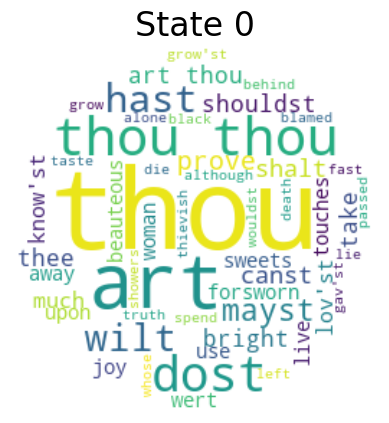

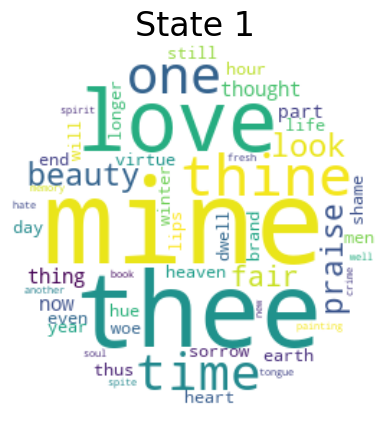

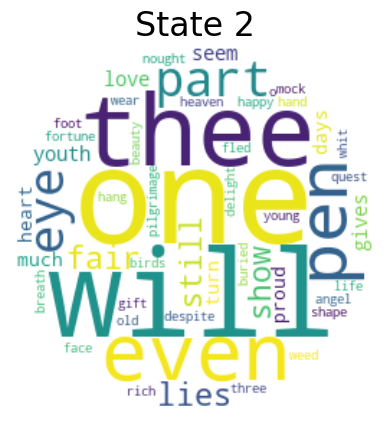

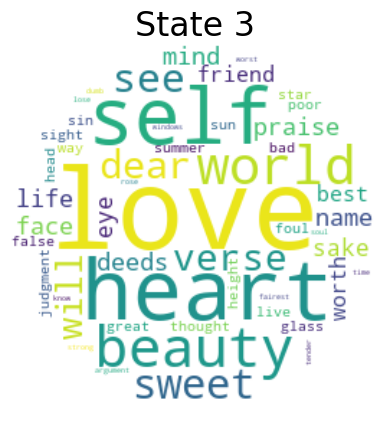

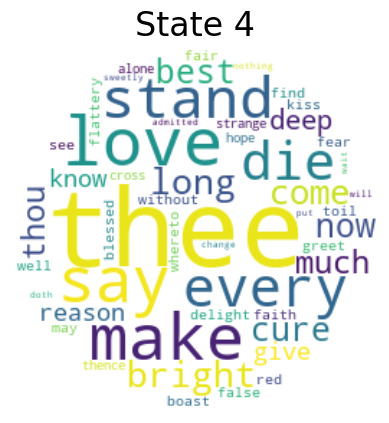

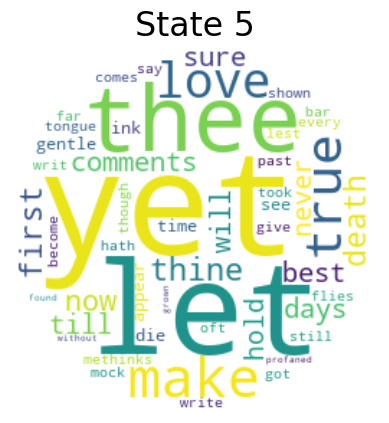

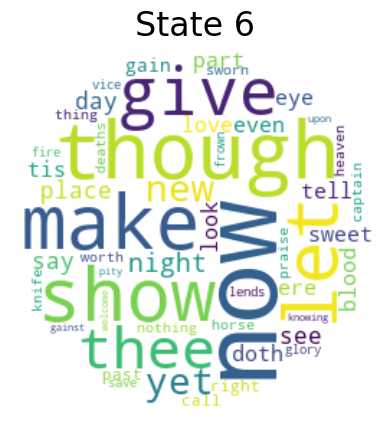

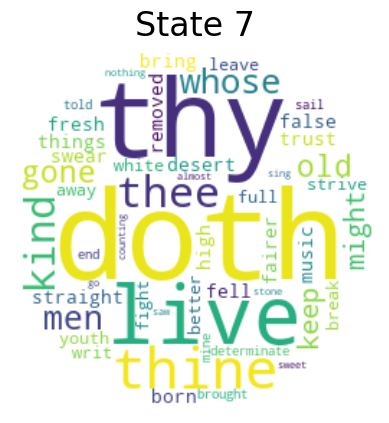

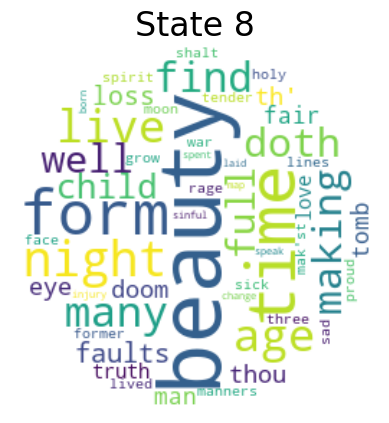

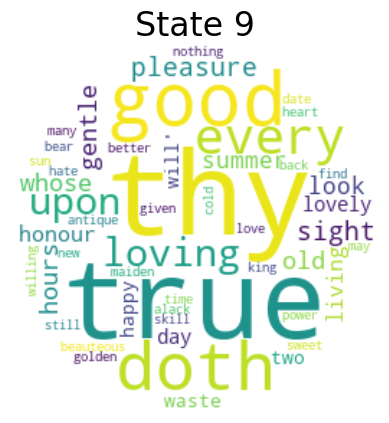

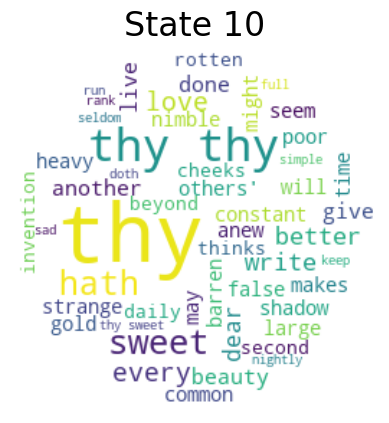

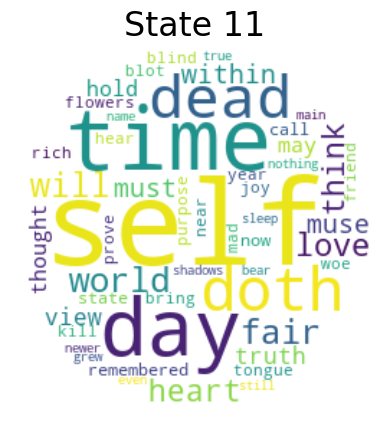

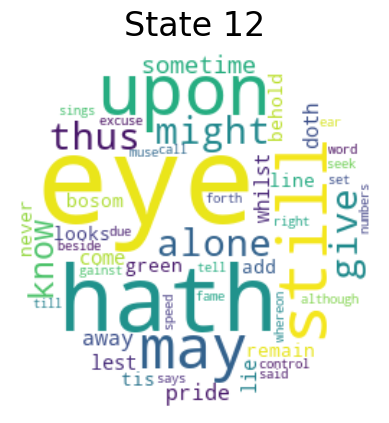

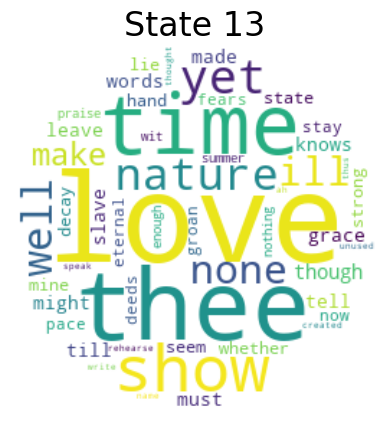

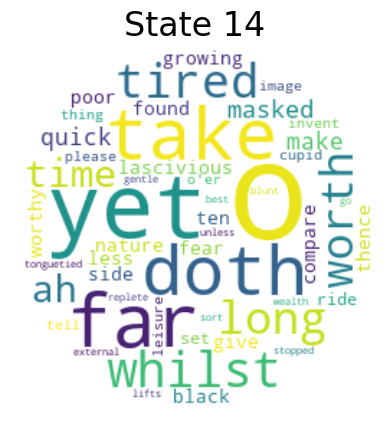

In [10]:
wordclouds = states_to_wordclouds(hmm_stanza_15_hidden, word_map)